
# Exemple 1 :Analyse du tr

## Information sur l'environnement python utilisé

Commande pour la création d'une machine virtuelle python et de installation des modules.

```
$ mkdir pip_serietemp
$ python3.9 -m venv pip_serietemp
$ source pip_serietemp/bin/activate
$ python3.9 -m pip install --upgrade pip
$ python3.9 -m pip install jupyter
$ python3.9 -m pip install pandas
$ python3.9 -m pip install matplotlib
$ python3.9 -m pip install scipy
$ jupyter notebook
```

## Lecture du fichier

Lecture des première lignes de : *trafficaerien.csv*

Ce fichier est créé à partir des données présent sur :

http://salledelecture-ext.aviation-civile.gouv.fr/externe/mouvementsDavions/index.php

https://www.ecologie.gouv.fr/statistiques-du-trafic-aerien

<pre><code>
Month;Volume
2014-01;190111
2014-02;181712
2014-03;211813
2014-04;241231
</pre></code>

On remarque un csv en mode texte avec 2 colonnes "Month" et "Volume" 

- *Month* : date (mois/an)

- *Volume* : nbre de mouvements d'avions au depart de France

La première colonne est une date AAAA-MM suivi d'un ";" puis d'un nombre entier.

In [1]:
# Clone the repo containing the dataset
!git clone -l -s https://github.com/mikeguzman1294/PythonDataScience.git cloned-repo
%cd cloned-repo/Courses/TimeSeries

Cloning into 'cloned-repo'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 47 (delta 7), reused 35 (delta 3), pack-reused 0
Unpacking objects: 100% (47/47), done.
/content/cloned-repo/Courses/TimeSeries


In [2]:
# import des librairies
import random
import math
from matplotlib.pyplot import *

import scipy
import scipy.signal

import numpy

import pandas as pd  # panda (dataframe,...)

In [3]:
# lecture d'un fichier csv 
# le séparateur est un ';' fonction "sep=';'"
# la fonction "parse_dates=['nom de la colonne']" permet de parser une date 
#                                  (format string vers format date)

# attention au chemin de votre fichier cvs, il est possible que 
# celui-ci soit différent
# on parse la date (attention 2014-01 devient 2014-01-01)
dfdb = pd.read_csv('Data/trafficaerien201401201904.csv',parse_dates=['Month'],sep=';')

dfdb1 = pd.read_csv('Data/trafficaerien201401202012.csv',parse_dates=['Month'],sep=';')


## Affichage des premières lignes et analyse descriptive

In [4]:
# Affichage du dataframe 
print(dfdb)
# Analyse descriptive des données
print("Analyse descriptive")
dfdb.describe()

        Month  Volume
0  2014-01-01  190111
1  2014-02-01  181712
2  2014-03-01  211813
3  2014-04-01  241231
4  2014-05-01  265480
..        ...     ...
59 2018-12-01  228309
60 2019-01-01  221577
61 2019-02-01  209841
62 2019-03-01  244329
63 2019-04-01  283034

[64 rows x 2 columns]
Analyse descriptive


,Volume
count,64.000000
mean,253723.968750
std,44860.669553
min,181712.000000
25%,212622.250000
50%,258379.000000
75%,293633.750000
max,337805.000000


- Tableau de 64 couples (date, nbre de vols) a priori de 2014-01 à 2019-04

In [5]:
# Affichage du dataframe (serie complete)
print(dfdb1)
# Analyse descriptive des données
print("Analyse descriptive")
dfdb1.describe()

        Month  Volume
0  2014-01-01  190111
1  2014-02-01  181712
2  2014-03-01  211813
3  2014-04-01  241231
4  2014-05-01  265480
..        ...     ...
89 2021-06-01  144906
90 2021-07-01  217312
91 2021-08-01  233954
92 2021-09-01  219482
93 2021-10-01  218345

[94 rows x 2 columns]
Analyse descriptive


,Volume
count,94.000000
mean,227230.744681
std,76698.667310
min,19007.000000
25%,197342.750000
50%,229011.000000
75%,291908.000000
max,340268.000000


- Tableau de 94 couples (date, nbre passagers) a priori de 2014-01 à 2021-10

Deux fonctions pour afficher une ou deux courbes sans oublier les labels, le titre,...

In [6]:
# Définition d'une fonction affichage, permet d'indiquer les différents label, 
# et un titre
def plot_df(df, x, y, title="qu'est-ce ?", xlabel='Date',\
            ylabel='Value', dpi=100):
    figure(figsize=(16,5), dpi=dpi)
    plot(x, y, color='tab:red')
    gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    show()
    
    
def plot_df2(df, x, y, x1, y1, title="qu'est-ce ?",\
             xlabel='Date', ylabel='Value', dpi=100):
    figure(figsize=(16,5), dpi=dpi)
    plot(x, y, x1, y1)
    gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    show()

## Affichage de la série

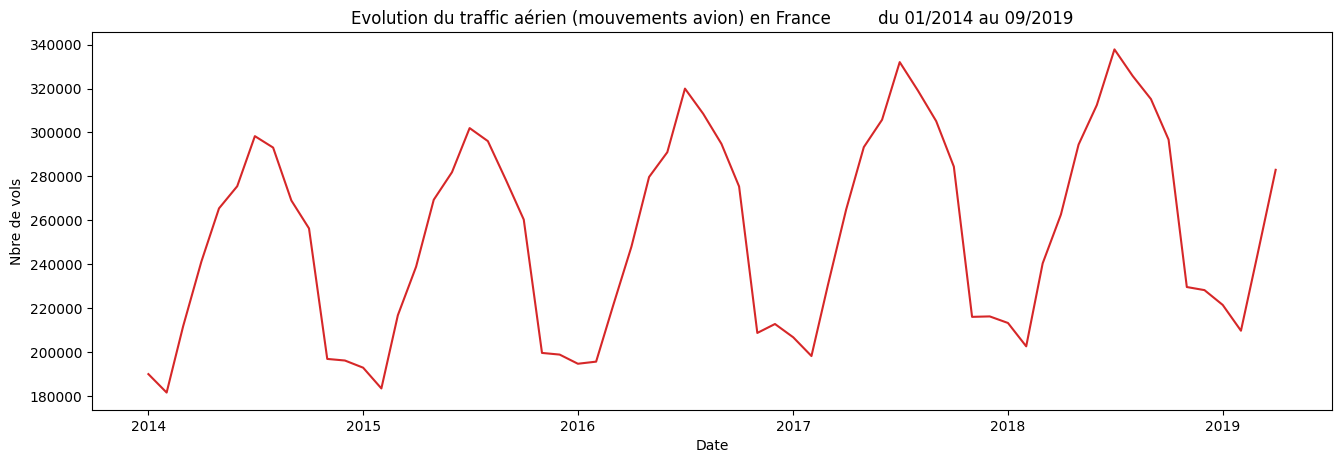

In [7]:
plot_df(dfdb, x=dfdb[['Month']], y = dfdb[['Volume']],\
        title='Evolution du traffic aérien (mouvements avion) en France \
        du 01/2014 au 09/2019',ylabel='Nbre de vols')

Attention à la série rien n'est stable

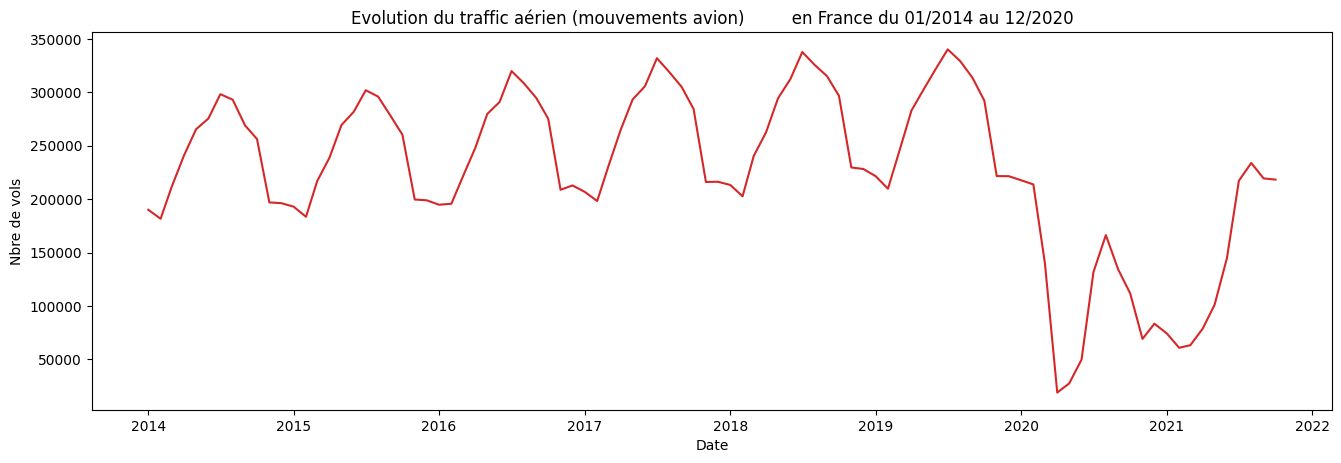

In [8]:
plot_df(dfdb1, x=dfdb1[['Month']], y = dfdb1[['Volume']],\
        title='Evolution du traffic aérien (mouvements avion) \
        en France du 01/2014 au 12/2020',ylabel='Nbre de vols')

On peut distinguer deux périodes [2014-01,2020-01] et [2020-02,2020-12].

# Modélisation
## Lissage par Moyenne Mobile 
### Calcul de la tendance

La série semble périodique de période 12 mois.

In [9]:
#initialisation
dftendance = dfdb.copy()

Application d'un moyenne mobile centrée sur 12 éléments MMC(12). Attention du poids de 0.5 aux extrémités et l'utilisation de 13 éléments

In [10]:
for k in range(6,64-6):
     val=0.
     # somme des 11 termes centraux
     for l in range(-5,6):
            val= val+dfdb.loc[k+l,'Volume']
     #print(k)
     # ajout des 2 termes du bord pondéré par un facteur 1/2
     val = val+ 0.5*dfdb.loc[k-6,'Volume']+0.5*dfdb.loc[k+6,'Volume']
     val = val/12;
     dftendance.loc[k,'Volume']=int(val)  
    
# ajouter des valeurs NaN sur les 6 premiers et les 6 dernirs derniers termes.
for k in range(0,6):
    dftendance.loc[k,'Volume']=np.NaN
    
for k in range(58,64):
    dftendance.loc[k,'Volume']=np.NaN
        

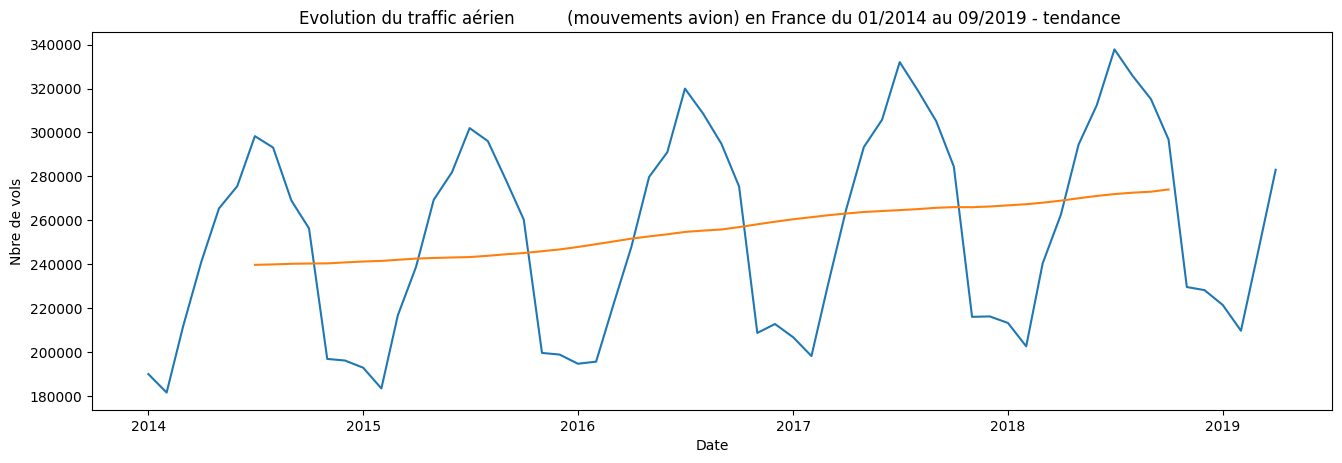

In [11]:
# Affichage de la série temporelle et de la tendance lissé
ylabel = 'Volume'
xlabel = 'Date (mensuelle)'

plot_df2(dfdb, x=dfdb[['Month']], y = dfdb[['Volume']], x1 = dftendance[['Month']],\
         y1 = dftendance[['Volume']], title='Evolution du traffic aérien \
         (mouvements avion) en France du 01/2014 au 09/2019 - tendance ',\
         ylabel='Nbre de vols')

La tendance a été calculée sur l'intervalle [2014-07,2018-10].

## Construction de la série différence
### Calcul de la série corrigée de la tendance

Sur la période [2014-07,2018-10], la tendance a té soustraite.

In [12]:
dfdiff = dfdb.copy()

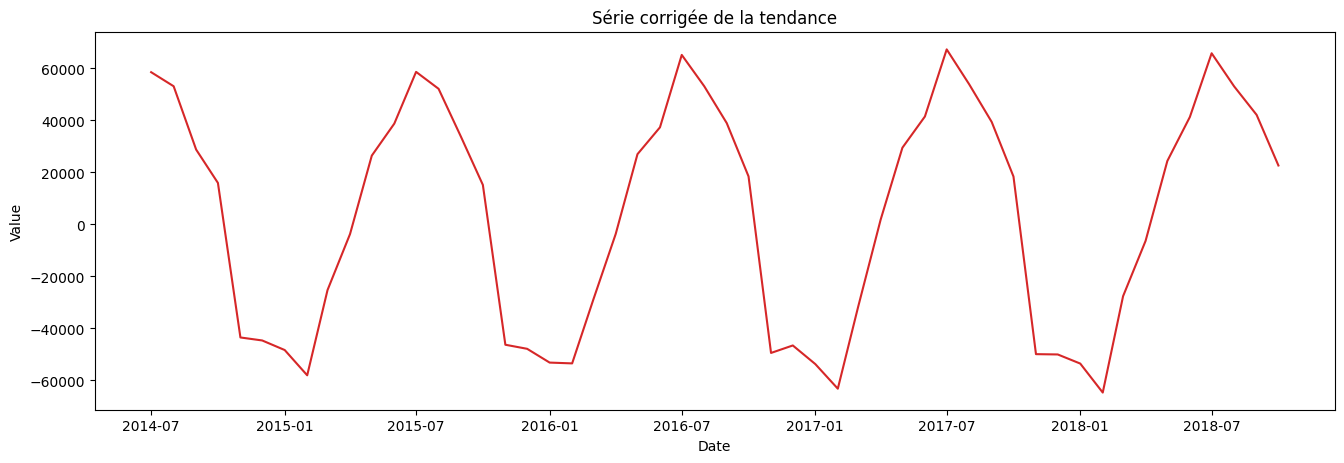

In [13]:
for k in range(6,64-6):
     dfdiff.loc[k,'Volume']=dfdb.loc[k,'Volume']-dftendance.loc[k,'Volume']
        
for k in range(0,6):
    dfdiff.loc[k,'Volume']=np.NaN
    
for k in range(58,64):
    dfdiff.loc[k,'Volume']=np.NaN
     
plot_df(dfdiff, x=dfdiff[['Month']], y = dfdiff[['Volume']],\
        title='Série corrigée de la tendance')  

On voit apparaitre un signal périodique. Les coefficients de la période varie d'une période à l'autre. La durée de la période est de 12 mois.

## Calcul des coefficients saisonniers

On utilise un nombre entier de période dans le signal (4*12 valeurs).

On va calculer les 12 coefficients de la périodes.

In [14]:
dperiode = pd.DataFrame({'A': [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],\
                         'Month':[1,2,3,4,5,6,7,8,9,10,11,12]})

Il serait intéressant de trouver le nom du mois ayant le numéro 1, 2,...

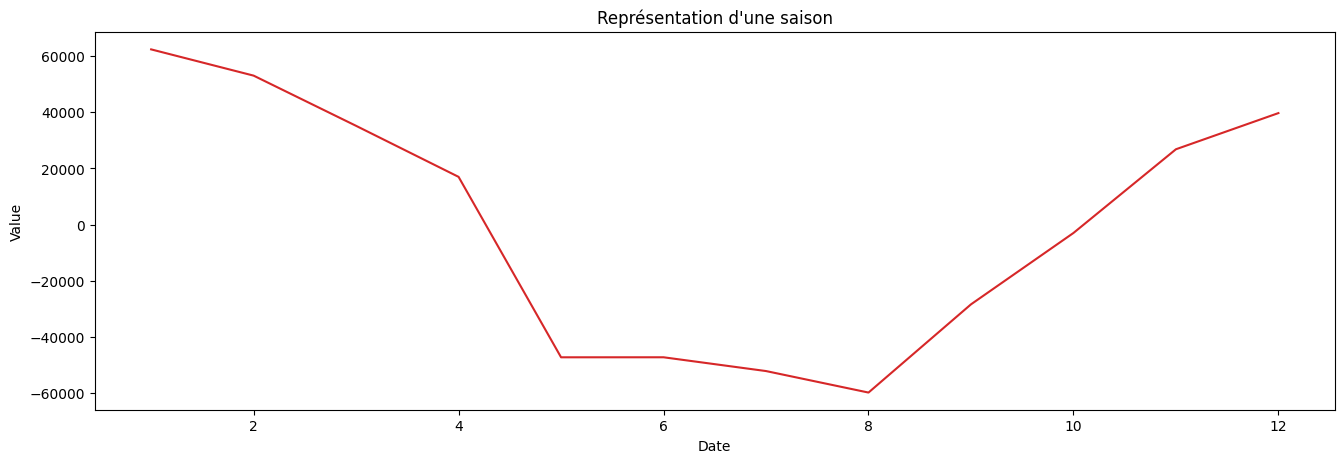

In [15]:
for k in range(0,12):
     val=0.
     for l in range(0,4):
            val= val+dfdiff.loc[k+l*12+6,'Volume']
     #print(k)
     val = val/4
     dperiode.loc[k,'A']=int(val) 
     #print(dperiode)
     #print(dperiode['A'][k])
 
#print(dperiode)
plot_df(dperiode, x=dperiode[['Month']], y = dperiode[['A']],\
        title='Représentation d\'une saison')  

Nous avons calculé la période moyenne.

## Centrage des coefficients saisonniers

Nous allons vérifier si cette période est de moyenne nulle (et la centrer si nécessaire)

In [16]:
val=0.
for k in range(0,12):
    val= val+dperiode['A'][k]
    
print("Moyenne des coefficients saisonniers : ",val/12.0)

for k in range(0,12):
    dperiode.loc[k,'A']= dperiode.loc[k,'A']-val/12.

Moyenne des coefficients saisonniers :  -290.6666666666667


On crée le signal périodique où chaque période est identique (et centrée).

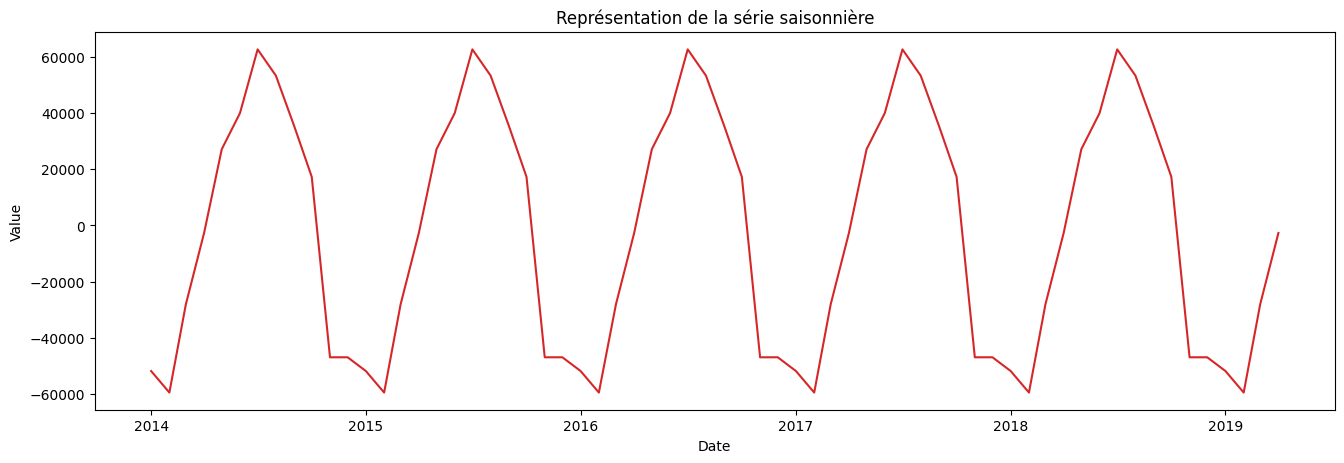

In [17]:
# Création de la série saisonnière et affichage
dfperiodo = dfdiff.copy()

for k in range(0,12):
     for l in range(0,4):
            dfperiodo.loc[k+l*12+6,'Volume']= dperiode.loc[k,'A']

#on complete les extrémités du signal
for l in range(0,6):
    dfperiodo.loc[l,'Volume']= dperiode.loc[l+6,'A']

for l in range(0,10):
    dfperiodo.loc[l+54,'Volume']= dperiode.loc[l,'A']
    
plot_df(dfperiodo, x=dfperiodo[['Month']], y = dfperiodo[['Volume']],\
        title = 'Représentation de la série saisonnière')              

## Construction de la série corrigée des variation saisonnières (CVS)

Récupération du signal corrigé des variations saisonnières.

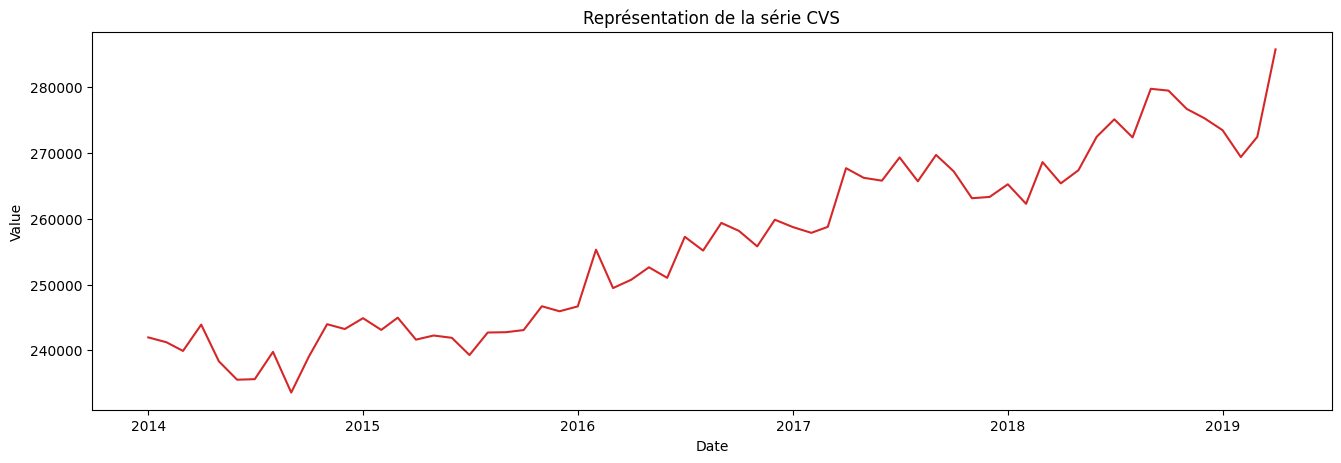

In [18]:
dfcvs = dfdb.copy()

for k in range(0,64):
     dfcvs.loc[k,'Volume']=dfdb.loc[k,'Volume']-dfperiodo.loc[k,'Volume']
        
plot_df(dfcvs, x=dfcvs[['Month']], y = dfcvs[['Volume']],\
        title='Représentation de la série CVS')

# Calcul et Affichage du résidu

On soustrait à la serie la série (lissée) ainsi que le partie périodique.

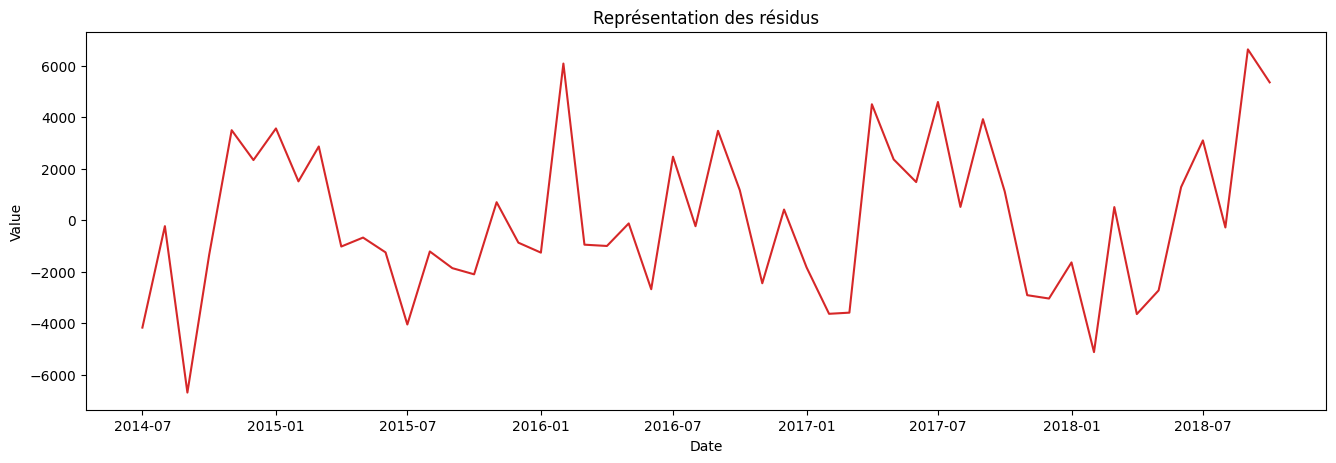

In [19]:
dfresidu = dftendance.copy()

for k in range(6,58):
     dfresidu.loc[k,'Volume']=dfdb.loc[k,'Volume']-dftendance.loc[k,'Volume']\
        -dfperiodo.loc[k,'Volume']
        
plot_df(dfresidu, x=dfresidu[['Month']], y = dfresidu[['Volume']],\
        title='Représentation des résidus')   

In [20]:
val = 0.
for k in range(6,55):
     val = val + dfresidu['Volume'][k]
        
print(val)

-10848.666666666599


Le résidu n'est pas de moyenne nulle.

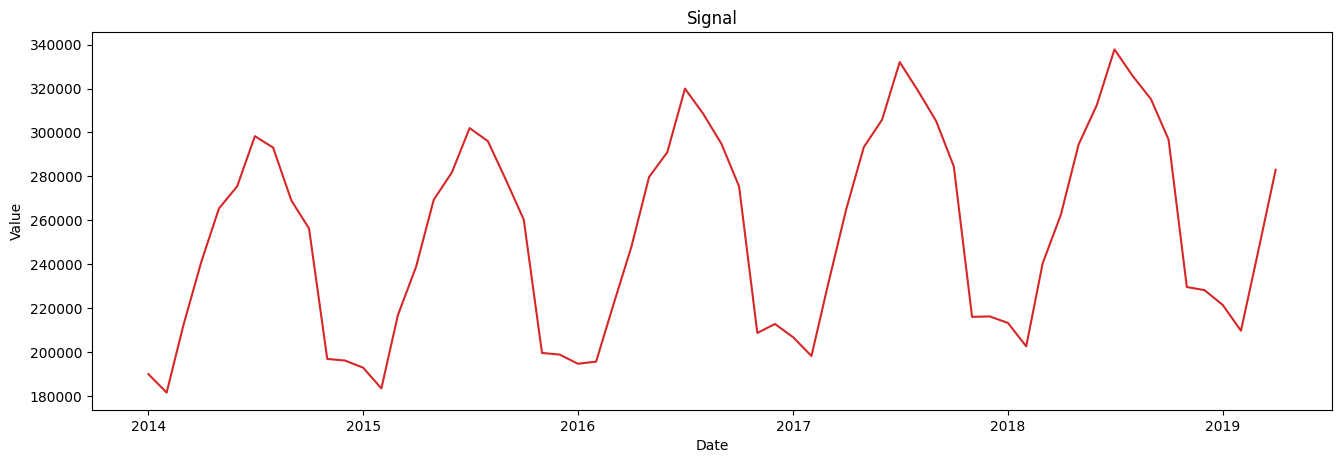

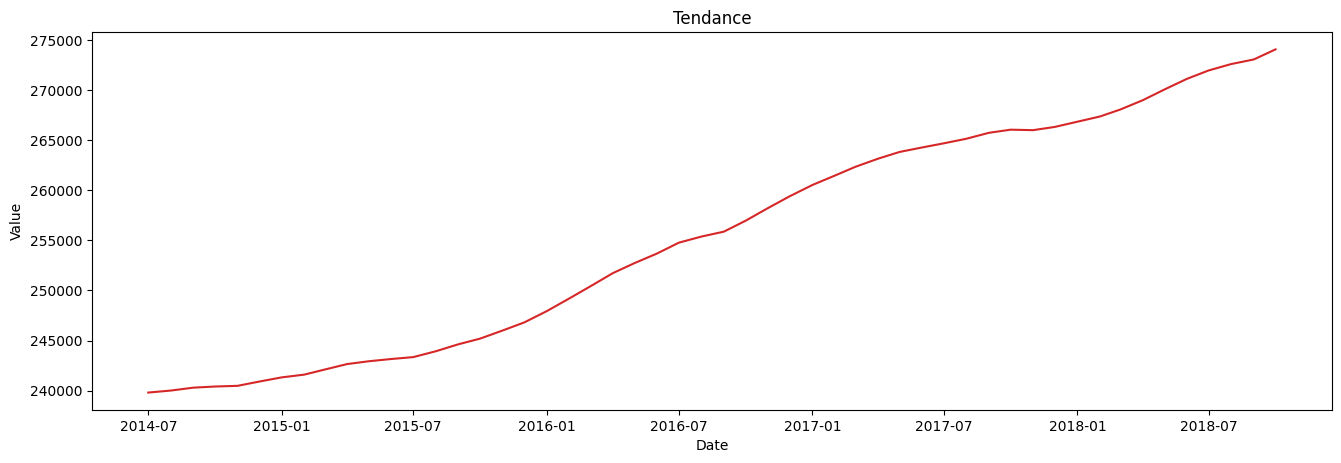

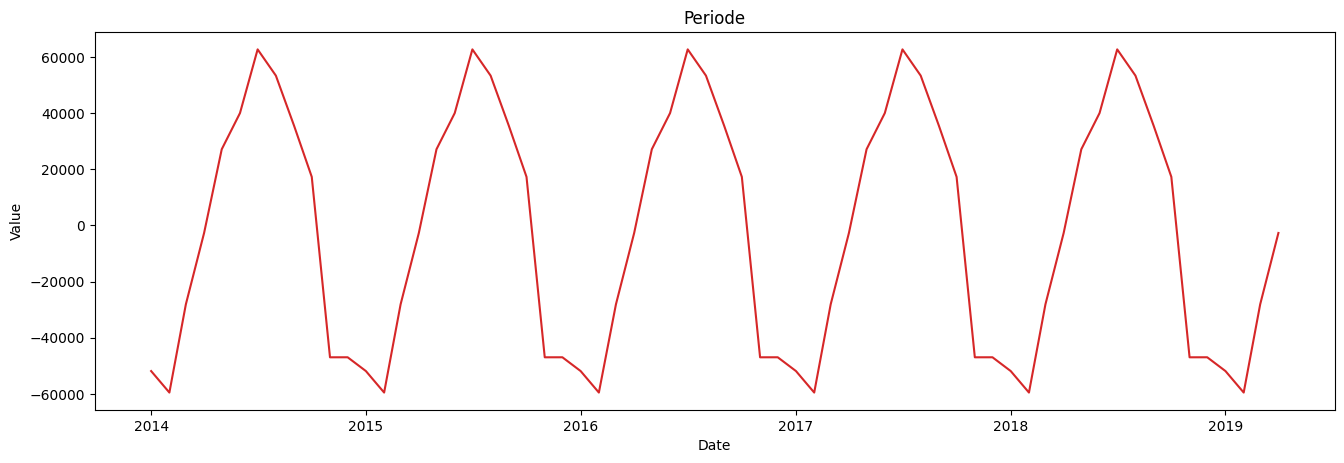

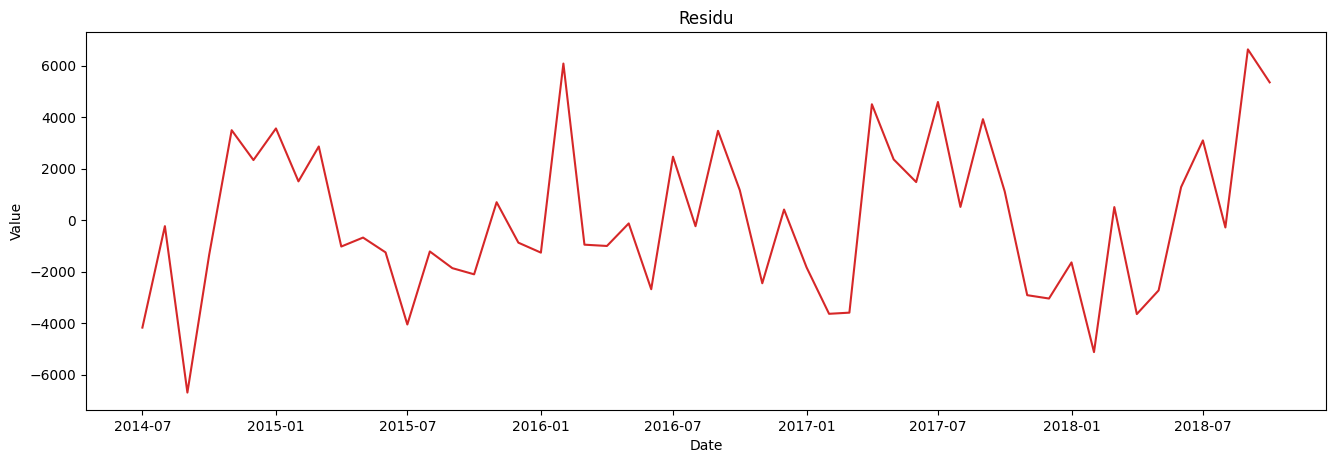

In [21]:
plot_df(dfdb, x=dfdb[['Month']], y = dfdb[['Volume']],title='Signal')
plot_df(dftendance, x=dftendance[['Month']], y = dftendance[['Volume']],title='Tendance')
plot_df(dfperiodo, x=dfperiodo[['Month']], y = dfperiodo[['Volume']],title='Periode') 
plot_df(dfresidu, x=dfresidu[['Month']], y = dfresidu[['Volume']],title='Residu') 

## Ajustement courbe de tendance

Modélisation par une droite (par minimisation des moindres carrés) du signal corrigé de la partie périodique.

Slope [694.76517857]
NRMSE: Volume    0.075438
dtype: float64
A    float64
dtype: object


[Text(0, 0.5, 'Volume'),
 Text(0.5, 0, 'Date (mensuelle)'),
 Text(0.5, 1.0, 'Tendance modélisé - Série CVS')]

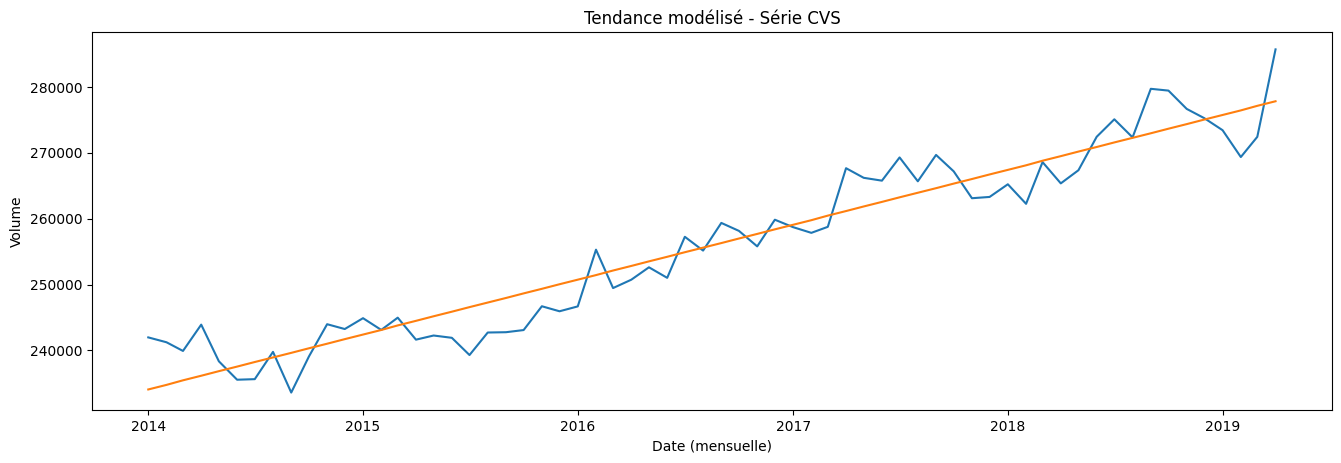

In [22]:
X=dftendance[['Month']][:]
y = dftendance[['Volume']][:]

X=dfcvs[['Month']][:]
y = dfcvs[['Volume']][:]

dpi=100

coefficients, residuals, _, _, _ = np.polyfit(range(len(y.index)),y,1,full=True)
mse = residuals[0]/(len(y.index))
nrmse = np.sqrt(mse)/(y.max() - y.min())
print('Slope ' + str(coefficients[0]))
print('NRMSE: ' + str(nrmse))
figure(figsize=(16,5), dpi=dpi)
plot(X[:]['Month'],y[:]['Volume'],label='Série CVS')

res = [coefficients[0]*x + coefficients[1] for x in range(len(X))]
dfr = pd.DataFrame(res,index = y.index,columns=['A'])
print(dfr.dtypes)

plot(X,res,label='Tendance modèlisée')
title = 'Tendance modélisé - Série CVS'

gca().set(title=title, xlabel=xlabel, ylabel=ylabel)


## Construction de la série lissée des prédictions

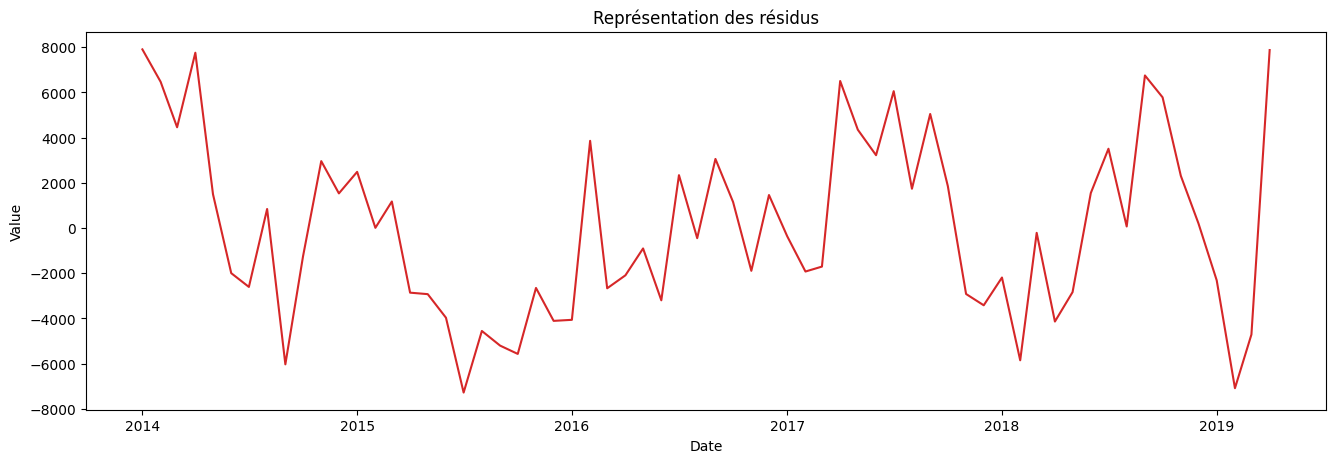

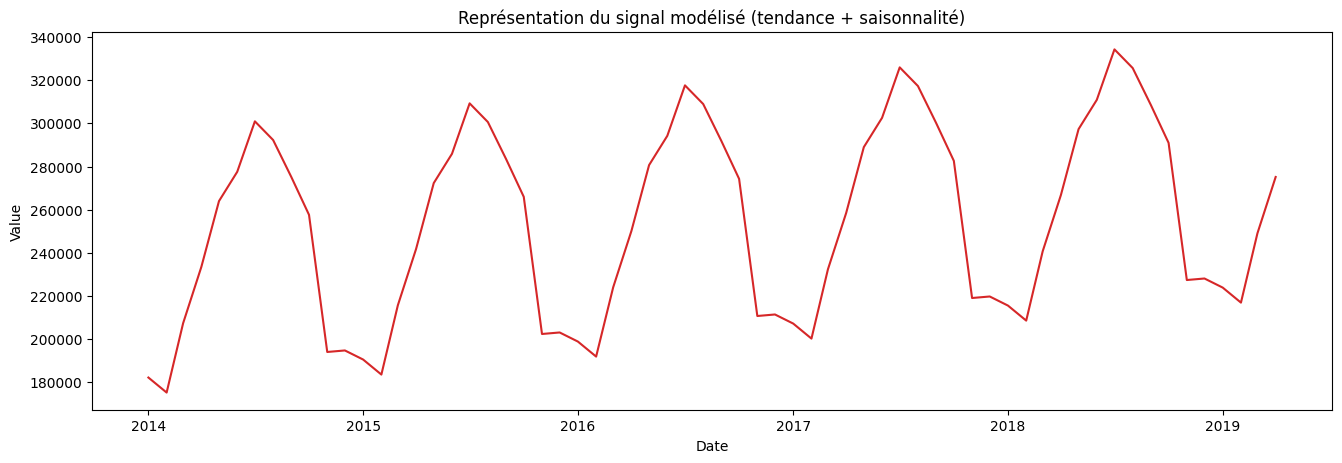

mse :  4130.010540924761


In [23]:
dfres = dfdiff.copy()

dfmod = dfdiff.copy()

for k in range(0,64):
     dfmod.loc[k,'Volume']=res[k]+dfperiodo.loc[k,'Volume']

for k in range(0,64):
     dfres.loc[k,'Volume']=dfdb.loc[k,'Volume']-res[k]-dfperiodo.loc[k,'Volume']


plot_df(dfresidu, x=X[:]['Month'], y = dfres[:]['Volume'],\
        title='Représentation des résidus')   

plot_df(dfresidu, x=X[:]['Month'], y = dfmod[:]['Volume'],\
        title='Représentation du signal modélisé (tendance + saisonnalité)') 
val = 0.
for k in range(0,64):
     val += dfres.loc[k,'Volume']*dfres.loc[k,'Volume']
 
import math 
val = math.sqrt(val/58-6+2)

print('mse : ',val)

[Text(0, 0.5, 'Nbre de vols'),
 Text(0.5, 0, 'Date (mensuelle)'),
 Text(0.5, 1.0, 'Courbe modélisé - Série brute')]

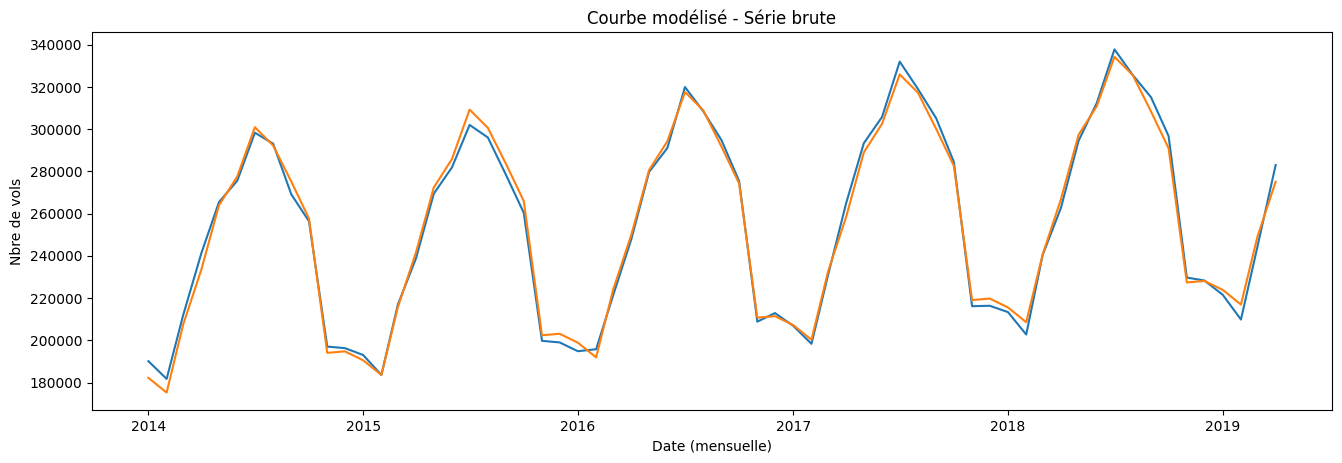

In [24]:
figure(figsize=(16,5), dpi=dpi)
plot(dfdb[:]['Month'],dfdb[:]['Volume'],label='Données brutes')

plot(X[:]['Month'],dfmod[:]['Volume'], label='Modèle')
ylabel = 'Nbre de vols'
xlabel = 'Date (mensuelle)'
title = 'Courbe modélisé - Série brute'
#legend =legend()
gca().set(title=title, xlabel=xlabel, ylabel=ylabel)

La même chose sur le signal complet (la modélisation étant effectué sur la première partie)

In [25]:
X1=dfdb1[['Month']][:]
res = [coefficients[0]*x + coefficients[1] for x in range(len(X1))]

dfperiodo1 = dfdb1.copy()
        
for k in range(0,12):
     for l in range(0,8):
            dfperiodo1.loc[k+l*12+6,'Volume']= dperiode.loc[k,'A']

# Création de la série saisonnière et affichage
            
#on complete les extrémités du signal
for l in range(0,6):
    dfperiodo1.loc[l,'Volume']= dperiode.loc[l+6,'A']

for l in range(0,6):
    dfperiodo1.loc[l+78,'Volume']= dperiode.loc[l,'A']
    
#plot_df(dfperiodo1, x=dfperiodo1[['Month']], y = dfperiodo1[['Volume']],title = 'Représentation de la série saisonnière')              

dfmod1 = dfdb1.copy()
dfmod1.describe()
for k in range(0,94):
     dfmod1.loc[k,'Volume']=res[k]+dfperiodo1.loc[k,'Volume']

[Text(0, 0.5, 'Nbre de vols'),
 Text(0.5, 0, 'Date (mensuelle)'),
 Text(0.5, 1.0, 'Courbe modélisé - Série brute')]

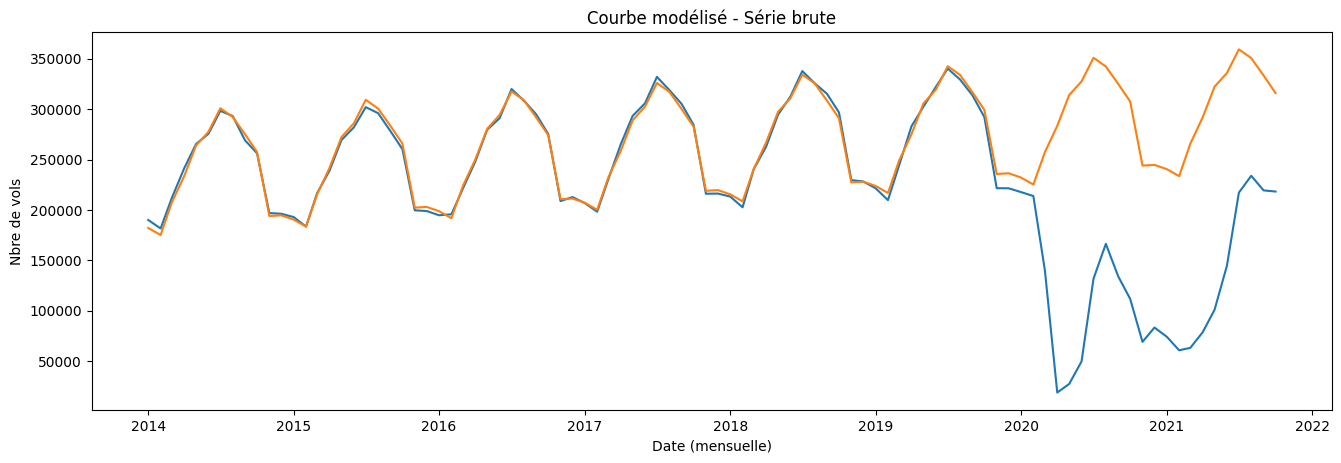

In [26]:
figure(figsize=(16,5), dpi=dpi)
plot(dfdb1['Month'],dfdb1['Volume'],label='Données brutes')

plot(dfdb1[:]['Month'],dfmod1[:]['Volume'], label='Modèle')
ylabel = 'Nbre de vols'
xlabel = 'Date (mensuelle)'
title = 'Courbe modélisé - Série brute'
#legend =legend()
gca().set(title=title, xlabel=xlabel, ylabel=ylabel)

## Quel est l'effet du covid19 sur les mouvements d'avions ?